In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.arima.model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import itertools 
import statsmodels.graphics.tsaplots as sgt
from arch import arch_model

# СКАЧИВАЕМ ДАННЫЕ

In [2]:
df = pd.read_csv('/windows/proga/global_mfdexport_1month_18072010_18072023.txt',sep=';')\
    .rename(columns={'<DATE>':'DATE','<OPEN>':'OPEN','<LOW>':'LOW','<CLOSE>':'CLOSE','<VOL>':'VOL','<HIGH>':'HIGH','<TICKER>':'TICKER'})\
    .drop(['<PER>','<TIME>','<OPENINT>'],1)
df.DATE = pd.to_datetime(df.DATE,format="%Y%m%d")

In [3]:
companies = df['TICKER'].unique()

# ПОДБОР ПАРАМЕТРОВ ДЛЯ ARIMA МОДЕЛИ ПО BIC И AIC ДЛЯ ПОЛНЫХ РЯДОВ

In [4]:
params_n = {}
for i in companies:
    company_df = df.loc[df['TICKER'] == i]
    if company_df.CLOSE.shape[0] == 157 : 
        company_df['earn'] = company_df.CLOSE.pct_change()
        series = company_df[['DATE','earn']].set_index('DATE').dropna()
        train_df = series.loc[:"2020-01-01"]
        test_df = series.loc["2020-02-01":]
        res = statsmodels.tsa.stattools.arma_order_select_ic(train_df.earn, ic=["aic", "bic"])
        params_n[i] = [res.bic_min_order , res.aic_min_order]

In [5]:
for i in params_n.keys() : 
    print(i,'bic{}'.format(params_n[i][0]),'aic{}'.format(params_n[i][1]) )

ГАЗПРОМ ао bic(0, 0) aic(0, 0)
Сбербанк bic(0, 0) aic(2, 2)
ЛУКОЙЛ bic(0, 0) aic(3, 1)
ГМКНорНик bic(0, 0) aic(0, 0)
Магнит ао bic(0, 0) aic(0, 0)
Татнфт 3ао bic(0, 0) aic(2, 0)
Новатэк ао bic(0, 0) aic(2, 2)
Сургнфгз bic(0, 0) aic(0, 0)
Сургнфгз-п bic(1, 0) aic(3, 1)
ПИК ао bic(0, 0) aic(2, 2)
Роснефть bic(0, 0) aic(0, 2)
Сбербанк-п bic(0, 0) aic(3, 2)
СевСт-ао bic(0, 0) aic(3, 0)
НЛМК ао bic(0, 0) aic(2, 2)
ИнтерРАОао bic(0, 0) aic(0, 0)
МТС-ао bic(2, 2) aic(2, 2)
ММК bic(0, 0) aic(3, 2)
Ростел -ао bic(0, 0) aic(1, 1)
ВТБ ао bic(0, 0) aic(0, 0)
Татнфт 3ап bic(0, 0) aic(0, 2)
Аэрофлот bic(0, 0) aic(1, 1)
Система ао bic(0, 0) aic(0, 0)
Транснф ап bic(0, 0) aic(0, 0)
РусГидро bic(0, 0) aic(0, 0)


# ПОДБОР ПАРАМЕТРОВ ДЛЯ ARIMA МОДЕЛИ ПО BIC И AIC ДЛЯ НЕПОЛНЫХ РЯДОВ

In [6]:
params = {}
for i in companies:
    company_df = df.loc[df['TICKER'] == i]
    if company_df.CLOSE.shape[0] != 157 : 
        company_df['earn'] = company_df.CLOSE.pct_change()
        series = company_df[['DATE','earn']].dropna().reset_index()
        train_df = series.loc[ : round(len(series)*0.7)].drop('index' , 1).set_index('DATE')
        test_df = series.loc[round(len(series)*0.7)+1 : ].drop('index' , 1).set_index('DATE')
        res = statsmodels.tsa.stattools.arma_order_select_ic(train_df.earn, ic=["aic", "bic"])
        params[i] = [res.bic_min_order , res.aic_min_order]

In [7]:
for i in params.keys() : 
    print(i,'bic{}'.format(params[i][0]),'aic{}'.format(params[i][1]) )

Полюс bic(1, 1) aic(1, 1)
Yandex clA bic(0, 0) aic(0, 0)
АЛРОСА ао bic(0, 0) aic(0, 1)
РУСАЛ ао bic(0, 0) aic(0, 0)
ФосАгро ао bic(0, 0) aic(0, 0)
TCS-гдр bic(0, 0) aic(0, 0)
AGRO-гдр bic(0, 0) aic(0, 0)
OZON-адр bic(0, 0) aic(0, 0)
Россети bic(0, 0) aic(0, 0)
МКБ ао bic(0, 0) aic(0, 0)
VK-гдр bic(2, 1) aic(2, 1)
ЭН+ГРУП ао bic(0, 0) aic(0, 1)
Сегежа bic(0, 0) aic(0, 0)
FIVE-гдр bic(0, 0) aic(0, 0)
Polymetal bic(0, 0) aic(0, 0)
МосБиржа bic(0, 1) aic(2, 1)
GLTR-гдр bic(0, 0) aic(1, 0)
FIXP-гдр bic(0, 1) aic(0, 1)


## ======================================================================

# [ПОЛН]СОЗДАЁМ РЯД ДОХОДНОСТЕЙ И РАЗДЕЛЯЕМ ЕГО НА TRAIN/TEST

In [9]:
company_df = df.loc[df['TICKER'] == 'ЛУКОЙЛ']

company_df['earn'] = company_df.CLOSE.pct_change()

series = company_df[['DATE','earn']].set_index('DATE').dropna()

train_df = series.loc[:"2020-01-01"]
test_df = series.loc["2020-02-01":]
print('Train df shape{}\nTest df shape{}\nДоля тестовой выборки равна {} '.format(train_df.shape,test_df.shape,len(test_df)/len(series)) )

Train df shape(114, 1)
Test df shape(42, 1)
Доля тестовой выборки равна 0.2692307692307692 


# [НЕПОЛН]СОЗДАЁМ РЯД ДОХОДНОСТЕЙ И РАЗДЕЛЯЕМ ЕГО НА TRAIN/TEST

In [142]:
company_df = df.loc[df['TICKER'] == 'FIXP-гдр']

company_df['earn'] = company_df.CLOSE.pct_change()

series = company_df[['DATE','earn']].dropna().reset_index()

train_df = series.loc[ : round(len(series)*0.7)].drop('index' , 1).set_index('DATE')
test_df = series.loc[round(len(series)*0.7)+1 : ].drop('index' , 1).set_index('DATE')

series = company_df[['DATE','earn']].set_index('DATE').dropna()

## ======================================================================

# СТРОИМ ACF , PACF НА TRAIN DF

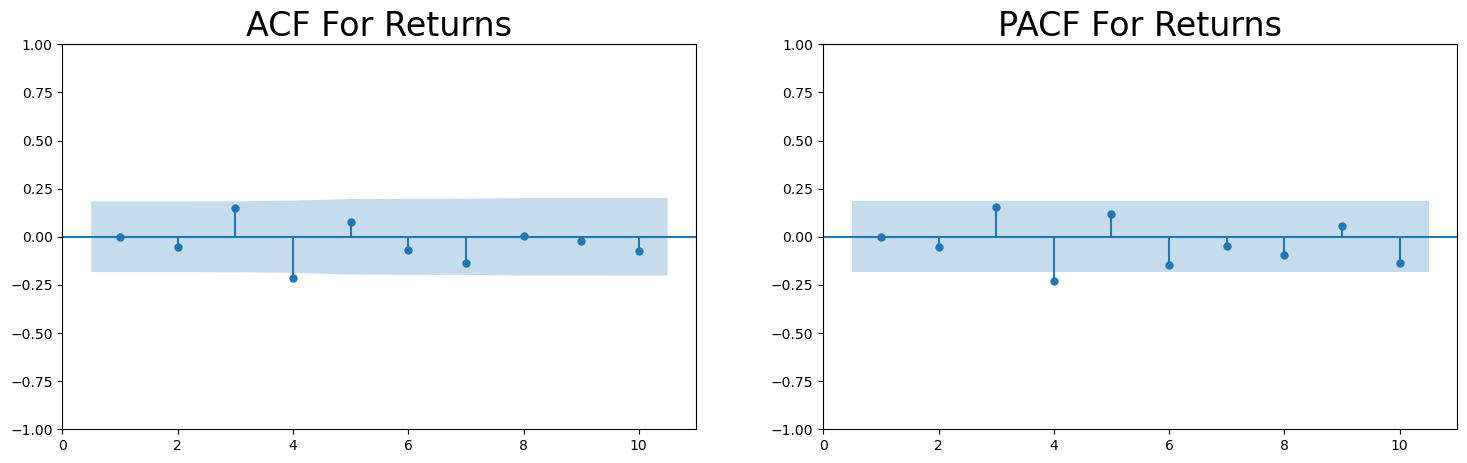

In [10]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df, zero = False, lags=10 , ax = axes[0])
sgt.plot_pacf(train_df, zero = False, lags=10 , ax = axes[1])

axes[0].set_title("ACF For Returns", size = 24)
axes[1].set_title("PACF For Returns", size = 24)

plt.show()

# СТРОИМ МОДЕЛЬ ARIMA(p,d,q)

In [15]:
model = ARIMA(train_df.earn[1:], order =(1,0,1))
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   earn   No. Observations:                  113
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 179.472
Date:                Tue, 22 Aug 2023   AIC                           -350.945
Time:                        13:49:05   BIC                           -340.035
Sample:                    09-01-2010   HQIC                          -346.518
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.006      2.423      0.015       0.003       0.025
ar.L1         -0.7526      0.133     -5.659      0.000      -1.013      -0.492
ma.L1          0.9312      0.078     11.970      0.000       0.779       1.084
sigma2         0.0024      0.000     11.905      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):               109.60
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.98
Prob(H) (two-sided):                  0.61   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

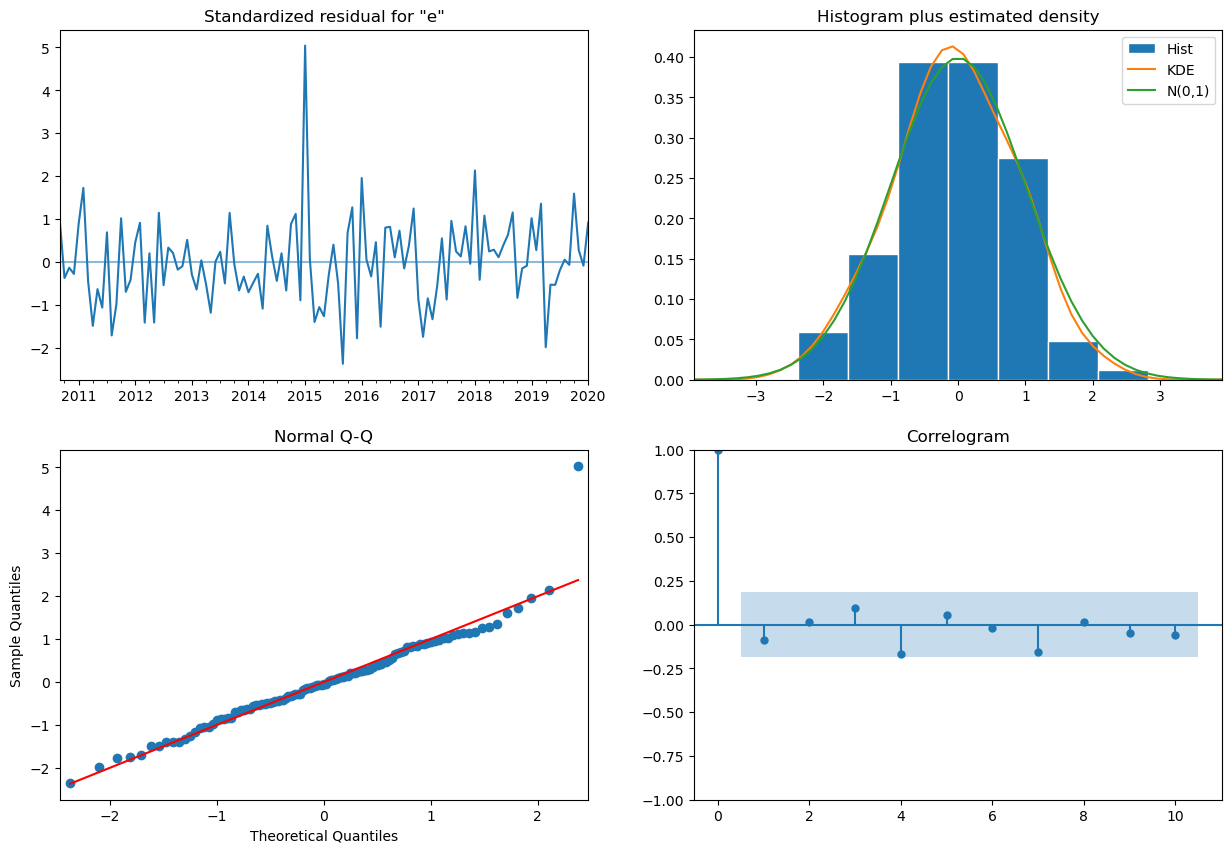

In [16]:
model_results.plot_diagnostics(figsize=(15, 10))
plt.show()

# СТРОИМ ПРОГНОЗ

In [17]:
arma_forecast = model_results.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
arma_predictions_df["Predictions"] = model_results.predict(start = test_df.index[0], end = test_df.index[-1])

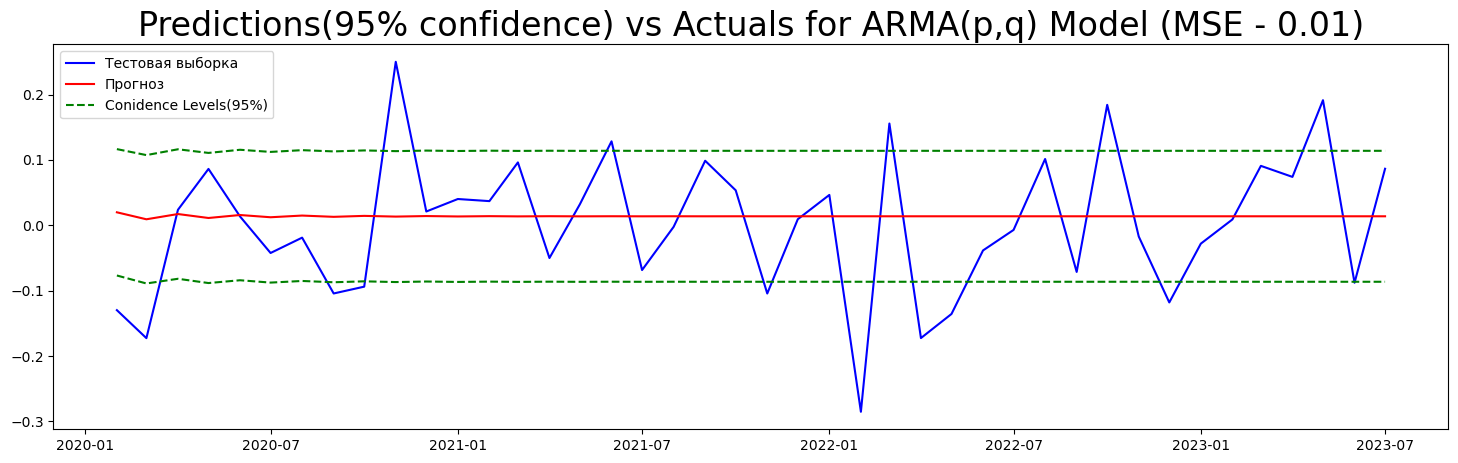

In [19]:
arma_mse = mean_squared_error(test_df.earn.values, arma_predictions_df["Predictions"])

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df.earn, color = "blue", label = "Тестовая выборка")

plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Прогноз")
plt.plot(arma_predictions_df["upper earn"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower earn"], color = "green", linestyle = "--")

plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(p,q) Model (MSE - {round(arma_mse, 2)})", size = 24)

plt.legend()
plt.show()

# ОСТАТКИ МОДЕЛИ

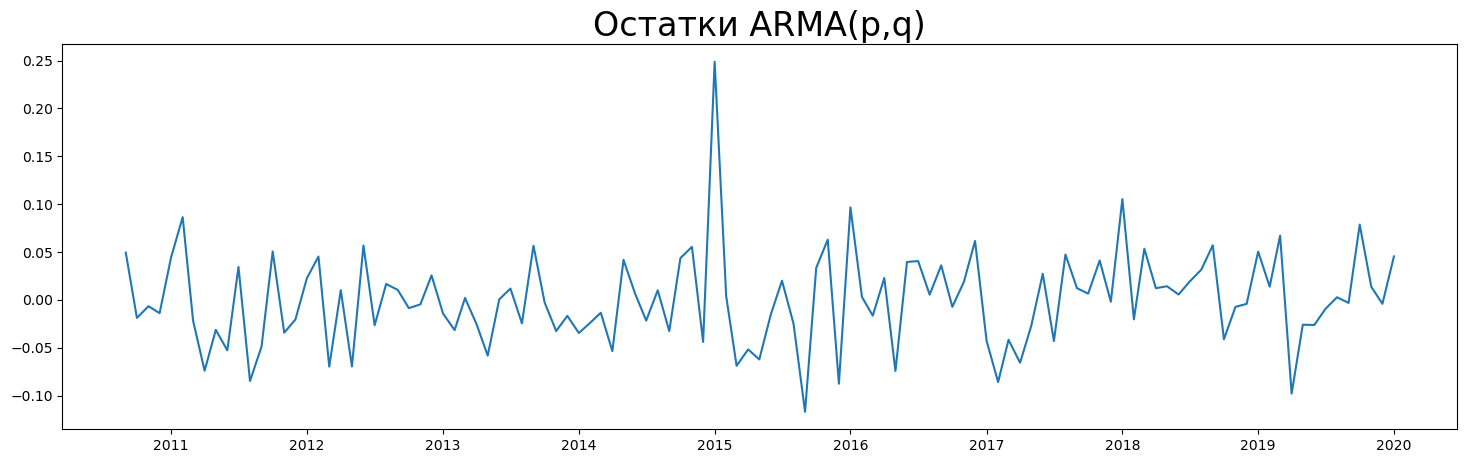

In [20]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(model_results.resid)
plt.title("Остатки ARMA(p,q)", size = 24)

plt.show()

# ACF ОСТАТКОВ

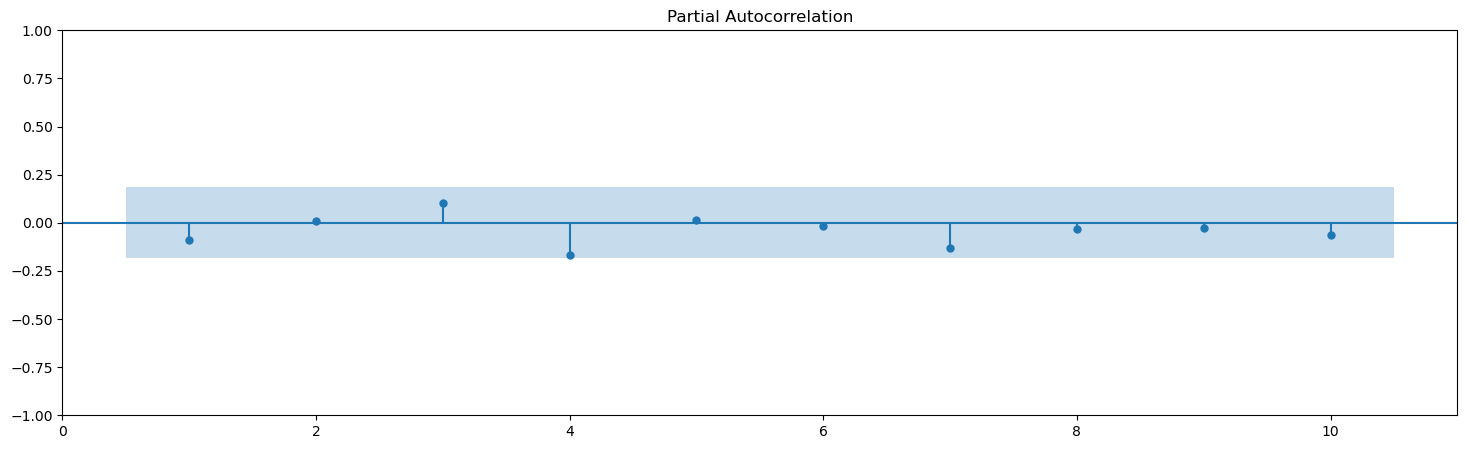

In [21]:
plt.rcParams["figure.figsize"] = 18, 5

sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 10)

plt.show()

# ПОДБИРАЕМ GARCH ДЛЯ ПРОГНОЗИРОВАНИЯ ВОЛАТИЛЬНОСТИ ОСТАТКОВ

In [94]:
resid_df = series.copy()
resid_df["earn_resid"] = resid_df["earn"].shift(1).loc[resid_df.index]
resid_df.loc[train_df.index[1]:train_df.index[-1], "earn_resid"] = model_results.resid

In [99]:
resid_df

,earn,earn_resid
DATE,,
2010-08-01,-0.052331,NaN
2010-09-01,0.063221,0.049510
2010-10-01,0.000629,-0.018766
2010-11-01,0.000502,-0.006560
2010-12-01,0.004035,-0.013792
...,...,...
2023-03-01,0.090852,0.008850
2023-04-01,0.073980,0.090852
2023-05-01,0.191357,0.073980


In [103]:
resid_model = arch_model(resid_df["earn_resid"][1:], p = 1, q = 1, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_df.index[0], update_freq = 5)
resid_model_results.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: -179.6367387062879
Iteration:     10,   Func. Count:     73,   Neg. LLF: -179.3975179692338
Iteration:     15,   Func. Count:    104,   Neg. LLF: -179.7005615868047
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.70067770732544
            Iterations: 17
            Function evaluations: 120
            Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             earn_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                179.701
Distribution:                  Normal   AIC:                          -351.401
Method:            Maximum Likelihood   BIC:                          -340.492
                                        No. Observations:                  113
Date:                Tue, Aug 22 2023   Df Residuals:                      112
Time:                        14:06:21   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.8559e-04  1.321e-02 -1.405e-02      0.989 [-2.608e-02,2.570e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.9649e-05  4.620e-04      0.216      0.829 [-8.058e-04,1.005e-03]
alpha[1]   3.3336e-09      0.208  1.606e-08      1.000      [ -0.407,  0.407]
beta[1]        0.9612      0.389      2.474  1.337e-02      [  0.200,  1.723]
=============================================================================

Covariance estimator: robust
"""

# ПРОГНОЗИРУЕМ

In [119]:
resid_forecasts = resid_model_results.forecast().residual_variance.loc[test_df.index].values

# ARMA(p,q)-ПРОГНОЗ + GARCH(p,q)-ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ

In [120]:
arma_garch_predictions_df = arma_predictions_df.copy()
arma_garch_predictions_df["lower earn"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
arma_garch_predictions_df["upper earn"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)

[]

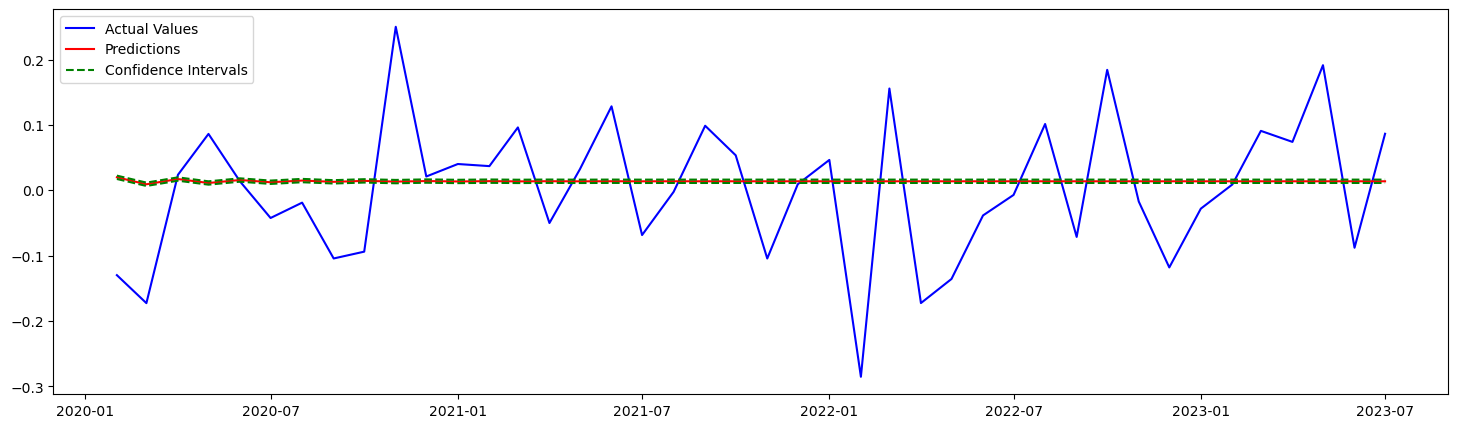

In [121]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["earn"], color = "blue", label = "Actual Values")

plt.plot(arma_garch_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower earn"][test_df.index], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper earn"][test_df.index], color = "green", linestyle = "--")

plt.legend()
plt.plot()